## Binary Regression on First Down Conversions

## Introduction
A common metric that is assessed in real time during games is a teams ability, or odds, that they will convert a specfic down and distance into a first down. Using play-by-play data, I will assess the odds and likelihood that teams from the NFC East and NFC North will convert a play into a first down on a given play, compared to what actually happened. I will be sure to filter plays out where punts or field goals took place, to get a more accurate idea of how this model will predict first down conversion.

In [1]:
## Libraries
library(tidyverse)
library(nflfastR)
library(broom)
library(ggplot2)
library(caret)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




In [2]:
## Load in Data
pbp_data <- load_pbp(2019:2025)

In [3]:
glimpse(pbp_data)

Rows: 312,103
Columns: 372
$ play_id                              <dbl> 1, 36, 51, 79, 100, 121, 148, 185…
$ game_id                              <chr> "2019_01_ATL_MIN", "2019_01_ATL_M…
$ old_game_id                          <chr> "2019090804", "2019090804", "2019…
$ home_team                            <chr> "MIN", "MIN", "MIN", "MIN", "MIN"…
$ away_team                            <chr> "ATL", "ATL", "ATL", "ATL", "ATL"…
$ season_type                          <chr> "REG", "REG", "REG", "REG", "REG"…
$ week                                 <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ posteam                              <chr> NA, "ATL", "ATL", "ATL", "ATL", "…
$ posteam_type                         <chr> NA, "away", "away", "away", "away…
$ defteam                              <chr> NA, "MIN", "MIN", "MIN", "MIN", "…
$ side_of_field                        <chr> NA, "MIN", "ATL", "ATL", "ATL", "…
$ yardline_100                         <dbl> NA, 35, 75, 83, 79, 67, 21, 31, 2…
$ game_date  

In [4]:
## create dataframes for NFC North and NFC East/One Hot Encode Pass and Run Location using caret library
pbp_nfc_north <- pbp_data |>
    filter(posteam %in% c("GB", "MIN", "CHI", "DET"))

pbp_nfc_east <- pbp_data |>
    filter(posteam %in% c("DAL", "NYG", "PHI", "WAS"))

In [5]:
## Filter to plays where punts or field goals were not attempted
nfc_north <- pbp_nfc_north |>
    filter(!is.na(epa), play_type %in% c("pass", "run"))

nfc_east <- pbp_nfc_east |>
    filter(!is.na(epa), play_type %in% c("pass", "run"))

## EDA

In [6]:
nfc_north |>
    filter(week != 0) |>
    group_by(play_type) |>
    summarise(first_down_rate = mean(first_down, na.rm = TRUE))

nfc_east |>
    filter(week != 0) |>
    group_by(play_type) |>
    summarise(first_down_rate = mean(first_down, na.rm = TRUE))

play_type,first_down_rate
<chr>,<dbl>
pass,0.3380264
run,0.2565355


play_type,first_down_rate
<chr>,<dbl>
pass,0.3110787
run,0.2705207


Warning message:
"The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead."


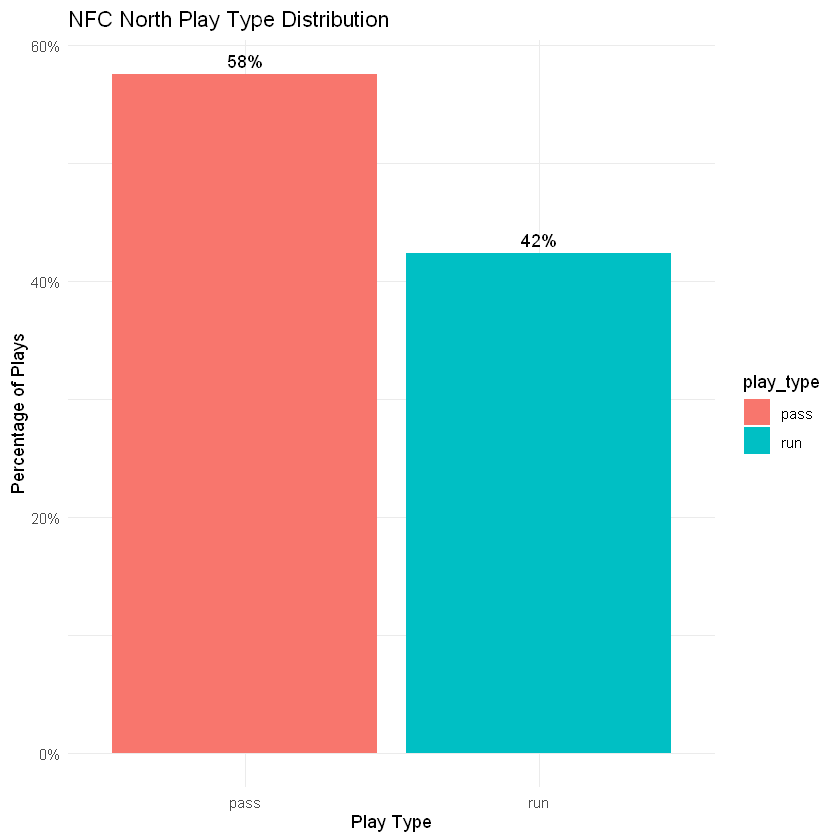

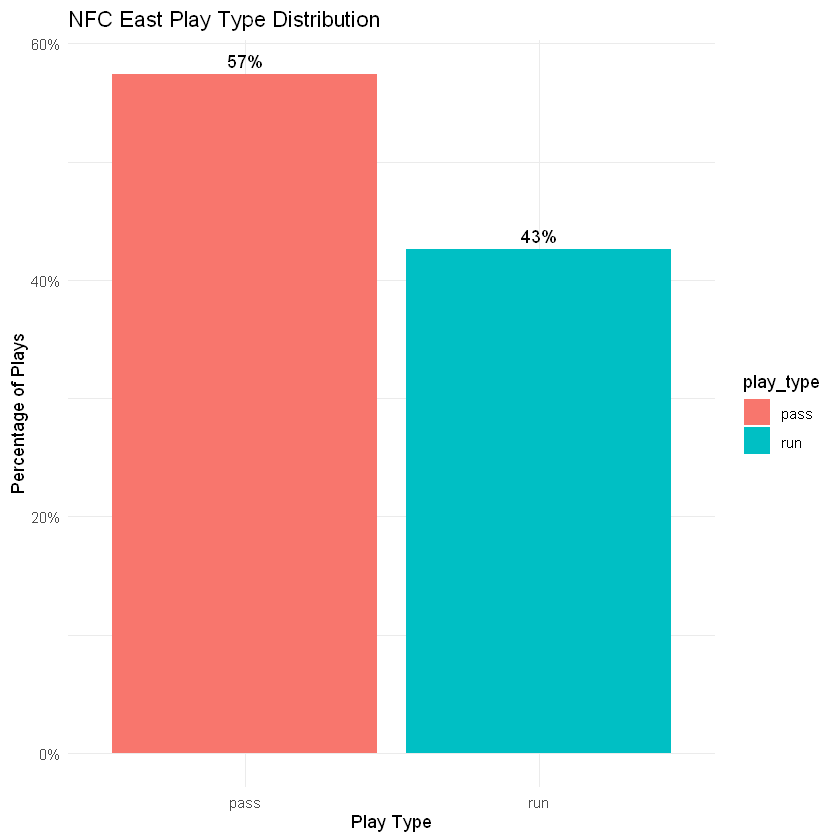

In [7]:
## Plot Play Distribution

nfc_north |>
    ggplot(aes(x = play_type, fill = play_type)) +
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    geom_text(stat='count', aes(y = (..count..)/sum(..count..), label = scales::percent((..count..)/sum(..count..))), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent_format()) +
    labs(title = "NFC North Play Type Distribution",
         x = "Play Type",
         y = "Percentage of Plays") +
    theme_minimal()

nfc_east |>
    ggplot(aes(x = play_type, fill = play_type)) +
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    geom_text(stat='count', aes(y = (..count..)/sum(..count..), label = scales::percent((..count..)/sum(..count..))), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent_format()) +
    labs(title = "NFC East Play Type Distribution",
         x = "Play Type",
         y = "Percentage of Plays") +
    theme_minimal()

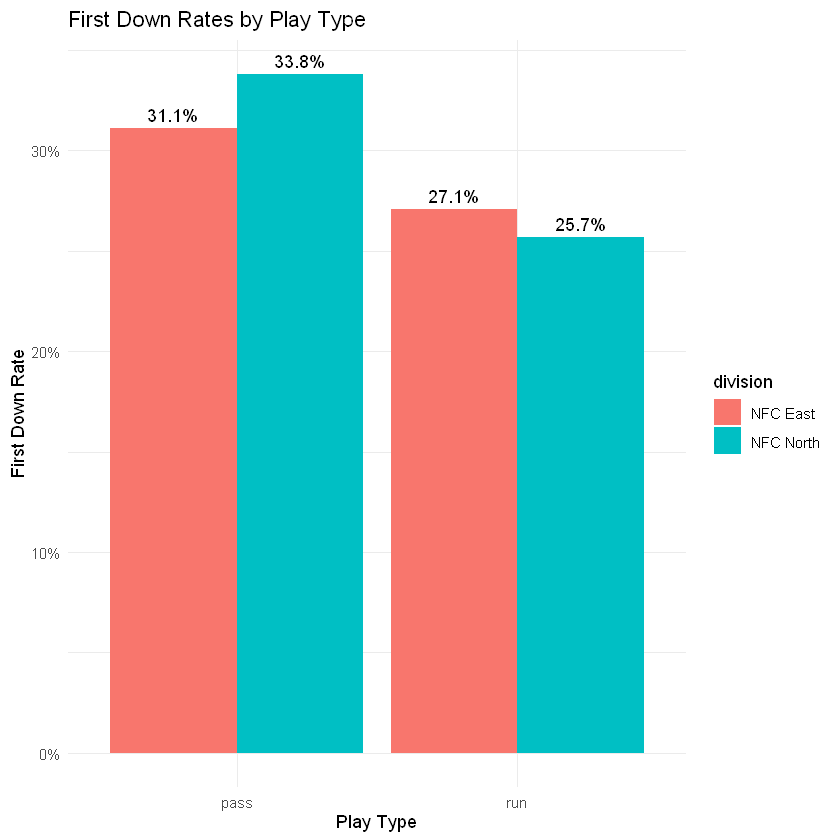

In [8]:
## Plot First Down Rates

nfc_north_fd <- nfc_north |>
    group_by(play_type) |>
    summarise(first_down_rate = mean(first_down, na.rm = TRUE)) |>
    mutate(division = "NFC North")

nfc_east_fd <- nfc_east |>
    group_by(play_type) |>
    summarise(first_down_rate = mean(first_down, na.rm = TRUE)) |>
    mutate(division = "NFC East")

fd_rates <- bind_rows(nfc_north_fd, nfc_east_fd)

fd_rates |>
    ggplot(aes(x = play_type, y = first_down_rate, fill = division)) +
    geom_bar(stat = "identity", position = "dodge") +
    geom_text(aes(label = scales::percent(first_down_rate)), position = position_dodge(width = 0.9), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent_format()) +
    labs(title = "First Down Rates by Play Type",
         x = "Play Type",
         y = "First Down Rate") +
    theme_minimal()

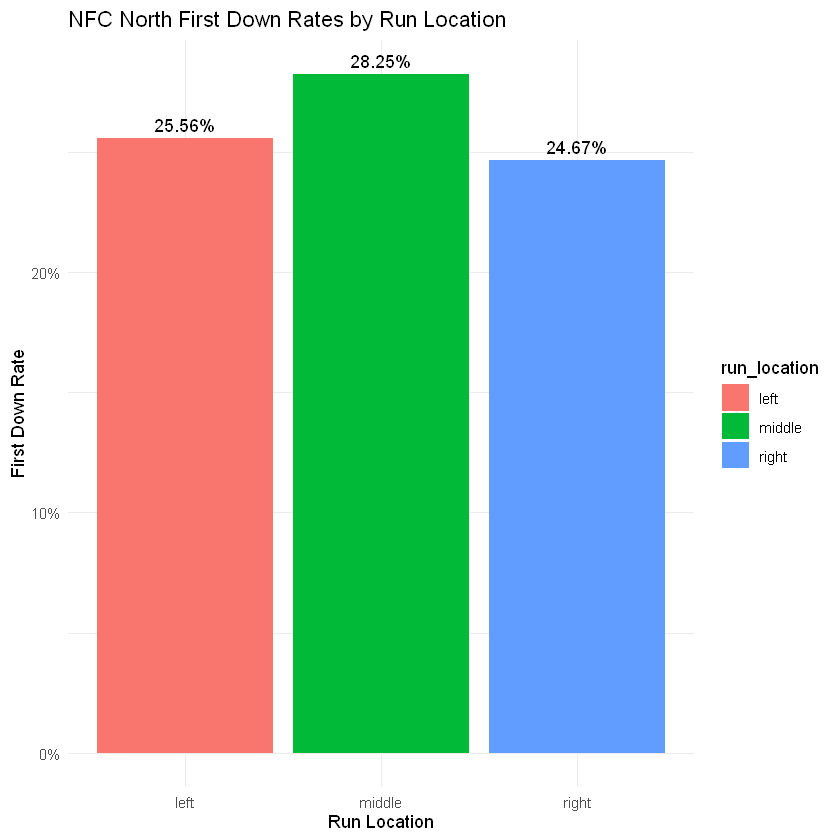

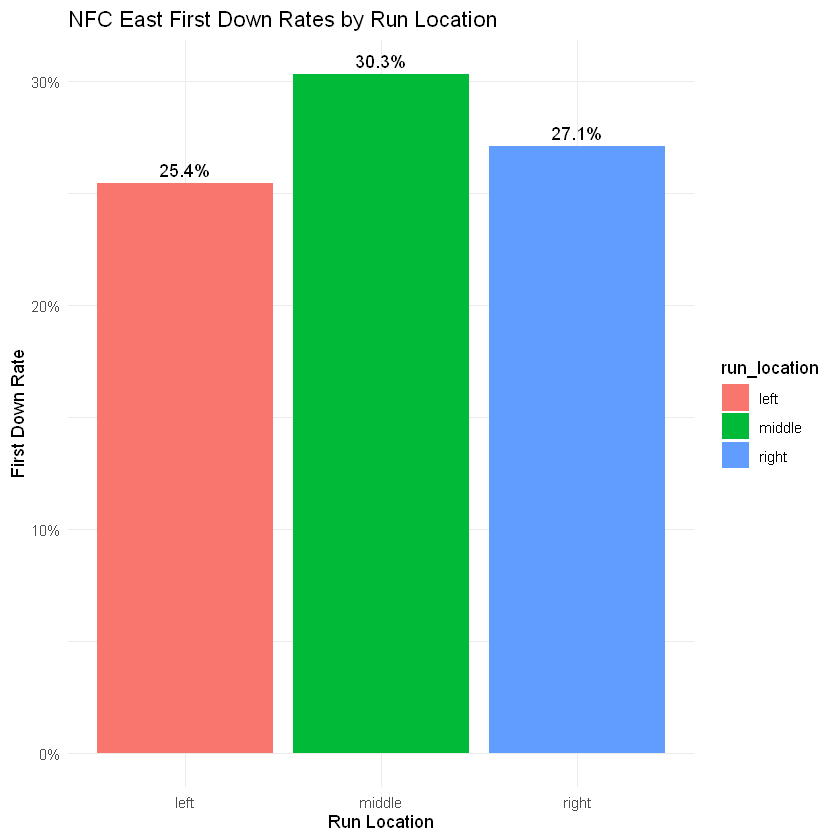

In [9]:
## First Down Conversion Rates by Run Location
nfc_north |>
    filter(play_type == "run" & !is.na(run_location)) |>
    group_by(run_location) |>
    summarise(first_down_rate = mean(first_down, na.rm = TRUE)) |>
    ggplot(aes(x = run_location, y = first_down_rate, fill = run_location)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = scales::percent(first_down_rate)), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent_format()) +
    labs(title = "NFC North First Down Rates by Run Location",
         x = "Run Location",
         y = "First Down Rate") +
    theme_minimal()

nfc_east |>
    filter(play_type == "run" & !is.na(run_location)) |>
    group_by(run_location) |>
    summarise(first_down_rate = mean(first_down, na.rm = TRUE)) |>
    ggplot(aes(x = run_location, y = first_down_rate, fill = run_location)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = scales::percent(first_down_rate)), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent_format()) +
    labs(title = "NFC East First Down Rates by Run Location",
         x = "Run Location",
         y = "First Down Rate") +
    theme_minimal()

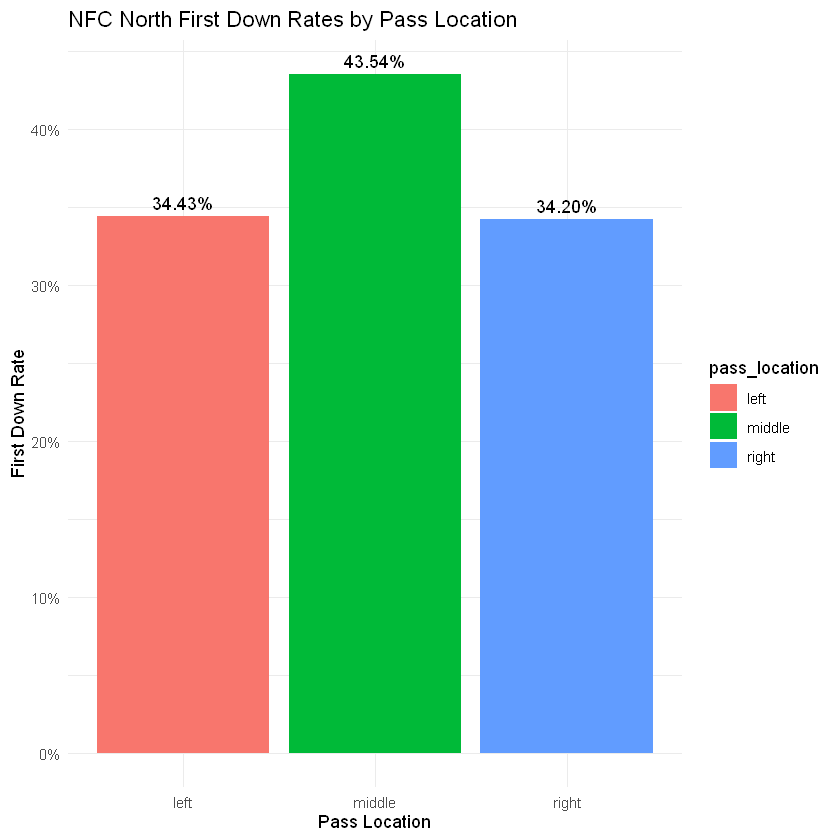

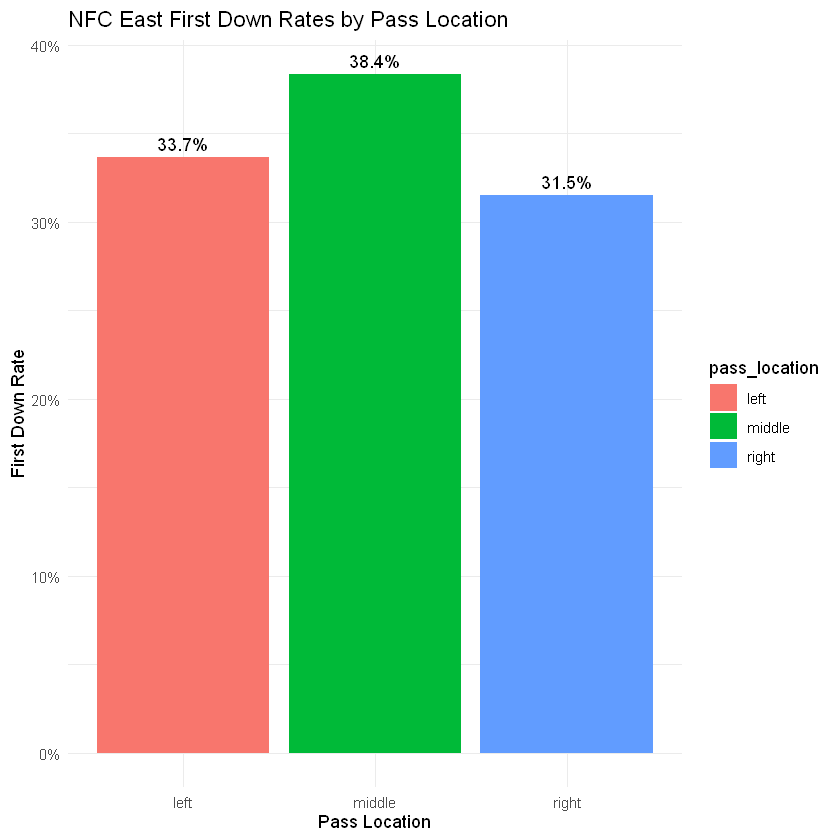

In [10]:
## First Down Conversion Rates by Pass Location
nfc_north |>
    filter(play_type == "pass" & !is.na(pass_location)) |>
    group_by(pass_location) |>
    summarise(first_down_rate = mean(first_down, na.rm = TRUE)) |>
    ggplot(aes(x = pass_location, y = first_down_rate, fill = pass_location)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = scales::percent(first_down_rate)), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent_format()) +
    labs(title = "NFC North First Down Rates by Pass Location",
         x = "Pass Location",
         y = "First Down Rate") +
    theme_minimal()

nfc_east |>
    filter(play_type == "pass" & !is.na(pass_location)) |>
    group_by(pass_location) |>
    summarise(first_down_rate = mean(first_down, na.rm = TRUE)) |>
    ggplot(aes(x = pass_location, y = first_down_rate, fill = pass_location)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = scales::percent(first_down_rate)), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent_format()) +
    labs(title = "NFC East First Down Rates by Pass Location",
         x = "Pass Location",
         y = "First Down Rate") +
    theme_minimal()

## Regression Model

In [32]:

## Perform Regression on First Down Conversion, only use columns that store numbers
nfc_north_model <- nfc_north |>
    select(pass_location, first_down, yardline_100, down, ydstogo, quarter_seconds_remaining, half_seconds_remaining, game_seconds_remaining, score_differential, posteam) |>
    filter(!is.na(pass_location))

nfc_east_model <- nfc_east |>
    select(pass_location, first_down, yardline_100, down, ydstogo, quarter_seconds_remaining, half_seconds_remaining, game_seconds_remaining, score_differential, posteam) |>
    filter(!is.na(pass_location))

nfc_north_lm <- glm(first_down ~ ., data = nfc_north_model, family = binomial)
summary(nfc_north_lm)

nfc_east_lm <- glm(first_down ~ ., data = nfc_east_model, family = binomial)
summary(nfc_east_lm)


Call:
glm(formula = first_down ~ ., family = binomial, data = nfc_north_model)

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                3.302e-01  1.060e-01   3.114 0.001844 ** 
pass_location             -8.238e-03  2.025e-02  -0.407 0.684176    
yardline_100               4.140e-03  7.721e-04   5.362 8.22e-08 ***
down                       1.221e-02  2.260e-02   0.540 0.588995    
ydstogo                   -1.603e-01  5.735e-03 -27.961  < 2e-16 ***
quarter_seconds_remaining  1.055e-04  8.124e-05   1.299 0.193936    
half_seconds_remaining     5.014e-05  4.487e-05   1.117 0.263799    
game_seconds_remaining     7.059e-06  2.009e-05   0.351 0.725251    
score_differential         2.647e-04  1.749e-03   0.151 0.879735    
posteamDET                 2.392e-01  5.143e-02   4.652 3.29e-06 ***
posteamGB                  1.604e-01  5.219e-02   3.073 0.002122 ** 
posteamMIN                 1.856e-01  5.196e-02   3.571 0.000355 ***
---
Sign


Call:
glm(formula = first_down ~ ., family = binomial, data = nfc_east_model)

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                6.710e-01  1.051e-01   6.383 1.73e-10 ***
pass_location             -5.897e-02  2.010e-02  -2.934  0.00335 ** 
yardline_100               3.337e-03  7.816e-04   4.270 1.95e-05 ***
down                       3.490e-02  2.268e-02   1.539  0.12390    
ydstogo                   -1.561e-01  5.827e-03 -26.784  < 2e-16 ***
quarter_seconds_remaining -8.498e-05  8.056e-05  -1.055  0.29150    
half_seconds_remaining     5.077e-05  4.512e-05   1.125  0.26056    
game_seconds_remaining    -2.400e-05  2.018e-05  -1.189  0.23430    
score_differential         1.531e-03  1.768e-03   0.866  0.38631    
posteamNYG                -2.053e-01  5.063e-02  -4.055 5.01e-05 ***
posteamPHI                -6.110e-02  4.905e-02  -1.246  0.21293    
posteamWAS                -1.367e-01  4.972e-02  -2.749  0.00598 ** 
---
Signi

In [33]:
## split data into training and testing sets
set.seed(42)

## define split ratio
train_ratio <- 0.7

## create random sample of row indices for training set
train_indices_north <- sample(seq_len(nrow(nfc_north_model)), size = floor(train_ratio * nrow(nfc_north_model)))
train_indices_east <- sample(seq_len(nrow(nfc_east_model)), size = floor(train_ratio * nrow(nfc_east_model)))

In [34]:
## Split the data
nfc_north_train <- nfc_north_model[train_indices_north, ]
nfc_north_test <- nfc_north_model[-train_indices_north, ]

nfc_east_train <- nfc_east_model[train_indices_east, ]
nfc_east_test <- nfc_east_model[-train_indices_east, ]

In [35]:
# train model on testing data
nfc_north_lm_train <- glm(first_down ~ ., data = nfc_north_train, family = binomial)
summary(nfc_north_lm_train)

nfc_east_lm_train <- glm(first_down ~ ., data = nfc_east_train, family = binomial)
summary(nfc_east_lm_train)


Call:
glm(formula = first_down ~ ., family = binomial, data = nfc_north_train)

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                2.936e-01  1.270e-01   2.312  0.02076 *  
pass_location              1.604e-02  2.428e-02   0.661  0.50877    
yardline_100               4.415e-03  9.283e-04   4.755 1.98e-06 ***
down                       1.027e-02  2.701e-02   0.380  0.70386    
ydstogo                   -1.598e-01  6.855e-03 -23.308  < 2e-16 ***
quarter_seconds_remaining  9.099e-05  9.773e-05   0.931  0.35183    
half_seconds_remaining     5.728e-05  5.377e-05   1.065  0.28674    
game_seconds_remaining    -1.677e-05  2.404e-05  -0.697  0.48551    
score_differential         1.747e-03  2.083e-03   0.839  0.40165    
posteamDET                 2.554e-01  6.160e-02   4.146 3.39e-05 ***
posteamGB                  1.627e-01  6.249e-02   2.604  0.00922 ** 
posteamMIN                 1.977e-01  6.228e-02   3.175  0.00150 ** 
---
Sign


Call:
glm(formula = first_down ~ ., family = binomial, data = nfc_east_train)

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                6.025e-01  1.257e-01   4.795 1.63e-06 ***
pass_location             -3.755e-02  2.393e-02  -1.569   0.1167    
yardline_100               3.839e-03  9.377e-04   4.094 4.24e-05 ***
down                       3.643e-02  2.693e-02   1.353   0.1761    
ydstogo                   -1.561e-01  6.957e-03 -22.432  < 2e-16 ***
quarter_seconds_remaining -4.839e-05  9.569e-05  -0.506   0.6130    
half_seconds_remaining     3.532e-05  5.367e-05   0.658   0.5105    
game_seconds_remaining    -2.771e-05  2.406e-05  -1.152   0.2495    
score_differential         2.256e-03  2.093e-03   1.078   0.2812    
posteamNYG                -1.854e-01  6.054e-02  -3.062   0.0022 ** 
posteamPHI                -2.121e-02  5.826e-02  -0.364   0.7158    
posteamWAS                -1.372e-01  5.933e-02  -2.312   0.0208 *  
---
Signi

In [36]:
# make predictions on test data
nfc_north_test <-
    nfc_north_test |>
    mutate(
        pred_first_down = predict(nfc_north_lm_train, newdata = nfc_north_test, type = "response")
    )

nfc_east_test <-
    nfc_east_test |>
    mutate(
        pred_first_down = predict(nfc_east_lm_train, newdata = nfc_east_test, type = "response")
    )

In [37]:
# evaluate model accuracy
nfc_north_test <-
    nfc_north_test |>
    mutate(
        pred_first_down = ifelse(pred_first_down > 0.5, 1, 0),
        accuracy = mean(pred_first_down == first_down, na.rm = TRUE)
    )

nfc_east_test <-
    nfc_east_test |>
    mutate(
        pred_first_down = ifelse(pred_first_down > 0.5, 1, 0),
        accuracy = mean(pred_first_down == first_down, na.rm = TRUE)
    )

In [38]:
## Overall Model Accuracy
mean(nfc_north_test$accuracy, na.rm = TRUE)
mean(nfc_east_test$accuracy, na.rm = TRUE)

[1] 0.6614548

[1] 0.6827283

In [39]:
## show predictions, include down, yardage, and team
nfc_north_test |>
    select(down, ydstogo, posteam, first_down, pred_first_down) |>
    head(20)

nfc_east_test |>
    select(down, ydstogo, posteam, first_down, pred_first_down) |>
    head(20)

down,ydstogo,posteam,first_down,pred_first_down
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
2,7,MIN,0,0
1,10,MIN,1,0
1,10,DET,0,0
2,9,DET,0,0
3,3,DET,1,1
2,6,DET,1,0
2,11,DET,0,0
1,10,DET,1,0
1,10,DET,0,0


down,ydstogo,posteam,first_down,pred_first_down
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
2,8,DAL,1,0
1,10,NYG,0,0
1,1,NYG,1,1
2,4,DAL,0,1
2,8,DAL,1,0
2,16,DAL,0,0
2,12,NYG,0,0
1,10,DAL,0,0
2,13,DAL,0,0


## Final Model Analysis
The difference between pass location and run location was very evident. It truly does show you that passing is such a hard thing to predict, as well as highlighting how important it is to ID the run game because it can be prevented easier. First Downs will always be hard to predict, and we can make general assumptions that most of the time in a 1st and 10 situation, the next play will not be a first down. We also can be confident that on a given play where it's 3rd and 25, the offense is very unlikely to convert a first down. In any case, the model showed %80 accuracy for our models that included the run_location, whereas the models for pass_location scored a %68. That's a whole 12 percent difference. 

## Conclusion
Overall, I enjoyed performing this regression. It was fun to think about first downs and what really affects the conversion rates for converting a first down on a given down and yardage. I ultimately think this subject should be saved for 3rd down and 4th down situations, where a team would be more likely to lean on these analytics. A lot of times teams use first and even second downs to setup the play they run on 3rd down. That is an example of how teams don't always stress about not converting on first second, because you always have that third and fourth chance. That's why it was important to me to add contextual pieces to the model like time remaining, or what kind of play was it (e.g. no huddle, shotgun) so that I could accurately capture the situation for that given play. 